In [33]:
# Imports
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights, ResNet50_Weights, ResNet34_Weights
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker


In [2]:
# Parameters
learning_rate = 0.001
batch_size = 64
epochs = 10
decisions_file_path = "../data/decisions.csv"
images_path = "../data/compressed_images"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Selected device: {device}")


Selected device: cuda


In [3]:
# Dataset
class AssistantDataset(Dataset):
    def __init__(self, images_dir: str, labels_file: str, transform=None):
        self.images_dir = images_dir
        self.labels = pd.read_csv(labels_file)
        self.transform = transform or transforms.ToTensor()
        
        self.label_encoders = {
            "activity": LabelEncoder(),
            "hearts": LabelEncoder(),
            "light_lvl": LabelEncoder(),
            "in_hand_item": LabelEncoder(),
            "target_mob": LabelEncoder(),
        }
        
        for col in self.label_encoders:
            self.label_encoders[col].fit(self.labels[col])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image_path = os.path.join(self.images_dir, self.labels.iloc[index, 0])
        image = Image.open(image_path).convert('RGB')
        
        targets = {col: self.label_encoders[col].transform([self.labels.iloc[index][col]])[0]
                   for col in self.label_encoders}
        
        if self.transform:
            image = self.transform(image)
        
        return image, targets
    

In [4]:
# Load Dataset and DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
ds = AssistantDataset(images_dir=images_path, labels_file=decisions_file_path, transform=transform)
train_ds, valid_ds = random_split(ds, [0.8, 0.2])

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)


In [5]:
# Calculate Class Weights
import numpy as np
class_weights = {}
for col, encoder in ds.label_encoders.items():
    # Transform labels to match with encoder classes
    labels = encoder.transform(ds.labels[col])
    weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights[col] = torch.tensor(weights, dtype=torch.float).to(device)


In [6]:
# Model Metrics and Loss Functions
class ModelMetrics:
    def __init__(self, num_classes, class_weights):
        self.loss_fns = {key: nn.CrossEntropyLoss(weight=class_weights[key]) for key in num_classes}

    def calculate_loss(self, predictions, targets):
        total_loss = 0
        losses = {}
        for key, pred in predictions.items():
            target = targets[key].to(pred.device)
            loss = self.loss_fns[key](pred, target)
            losses[key] = loss.item()
            total_loss += loss
        return total_loss, losses

    def calculate_accuracy(self, predictions, targets):
        accuracies = {}
        for key, pred in predictions.items():
            target = targets[key].to(pred.device)
            acc = (pred.argmax(dim=1) == target).float().mean().item()
            accuracies[key] = acc
        return accuracies


In [7]:
# Model
class AssistantClassifier(nn.Module):
    def __init__(self, num_classes):
        super(AssistantClassifier, self).__init__()
        
        self.cnn = models.resnet34(weights=ResNet34_Weights.DEFAULT)
        
        for param in list(self.cnn.parameters())[:6]:
            param.requires_grad = False
        for param in list(self.cnn.parameters())[6:]:
            param.requires_grad = True
        
        self.cnn.fc = nn.Identity()
        
        self.fc = nn.ModuleDict({
            key: nn.Linear(512, num) for key, num in num_classes.items()
        })

    def forward(self, x):
        features = self.cnn(x)
        return {key: layer(features) for key, layer in self.fc.items()}

In [8]:
# Training Setup
num_classes = {col: len(ds.label_encoders[col].classes_) for col in ds.label_encoders}
model = AssistantClassifier(num_classes).to(device)
metrics = ModelMetrics(num_classes, class_weights)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

In [9]:
# Training Loop
def fit(training_accuracies: dict, validation_accuracies: dict, training_losses: list, validation_losses: list, epochs: int):
    for epoch in range(epochs):
        model.train()
        total_loss_train = 0.
        total_accuracies_train = {key: 0. for key in num_classes}
        
        for images, targets in train_dl:
            images = images.to(device)
            targets = {key: val.clone().detach().to(device) for key, val in targets.items()}
            predictions = model(images)
            loss, batch_losses = metrics.calculate_loss(predictions, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss_train += loss.item()
            batch_accuracies = metrics.calculate_accuracy(predictions, targets)
            for key in total_accuracies_train:
                total_accuracies_train[key] += batch_accuracies[key]
    
        avg_loss = total_loss_train / len(train_dl)
        training_losses.append(avg_loss)
        avg_train_accuracies = {key: acc / len(train_dl) for key, acc in total_accuracies_train.items()}
        for key in training_accuracies.keys():
            training_accuracies[key].append(avg_train_accuracies[key])
        
        print(f"[TRAIN] Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
        print("Accuracies:", avg_train_accuracies)
        
        model.eval()
        with torch.no_grad():
            total_loss_valid = 0.
            total_accuracies_valid = {key: 0. for key in num_classes}
            
            for images, targets in valid_dl:
                images = images.to(device)
                targets = {key: val.clone().detach().to(device) for key, val in targets.items()}
                predictions = model(images)
                loss, batch_losses = metrics.calculate_loss(predictions, targets)
                
                total_loss_valid += loss.item()
                batch_accuracies = metrics.calculate_accuracy(predictions, targets)
                for key in total_accuracies_valid:
                    total_accuracies_valid[key] += batch_accuracies[key]
            
            avg_loss = total_loss_valid / len(valid_dl)
            validation_losses.append(avg_loss)
            avg_valid_accuracies = {key: acc / len(valid_dl) for key, acc in total_accuracies_valid.items()}
            for key in validation_accuracies.keys():
                validation_accuracies[key].append(avg_valid_accuracies[key])
        
        print(f"[VALID] Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
        print("Accuracies:", avg_valid_accuracies)
        

In [10]:
training_accuracies = {
    "activity": [],
    "hearts": [],
    "light_lvl": [],
    "in_hand_item": [],
    "target_mob": []
}
validation_accuracies = {
    "activity": [],
    "hearts": [],
    "light_lvl": [],
    "in_hand_item": [],
    "target_mob": []
}
training_losses, validation_losses = [], []
fit(
    validation_accuracies=validation_accuracies,
    training_accuracies=training_accuracies,
    training_losses=training_losses,
    validation_losses=validation_losses,
    epochs=epochs,
)

[TRAIN] Epoch 1/10 - Loss: 5.4578
Accuracies: {'activity': 0.9044237012987013, 'hearts': 0.3311913780771293, 'light_lvl': 0.744453463461492, 'in_hand_item': 0.6998106063186348, 'target_mob': 0.6036480881951072}
[VALID] Epoch 1/10 - Loss: 9.6621
Accuracies: {'activity': 0.6234375, 'hearts': 0.30546875, 'light_lvl': 0.7703125, 'in_hand_item': 0.4546875, 'target_mob': 0.521875}
[TRAIN] Epoch 2/10 - Loss: 3.9249
Accuracies: {'activity': 0.9721996753246753, 'hearts': 0.49235660186061614, 'light_lvl': 0.773854617948656, 'in_hand_item': 0.7821744231434612, 'target_mob': 0.710565476448505}
[VALID] Epoch 2/10 - Loss: 6.0325
Accuracies: {'activity': 0.8359375, 'hearts': 0.36484375, 'light_lvl': 0.78046875, 'in_hand_item': 0.703125, 'target_mob': 0.615625}
[TRAIN] Epoch 3/10 - Loss: 3.4739
Accuracies: {'activity': 0.979099025974026, 'hearts': 0.5524891777472063, 'light_lvl': 0.7851957071137119, 'in_hand_item': 0.8041801948051948, 'target_mob': 0.752435064935065}
[VALID] Epoch 3/10 - Loss: 4.5600


In [11]:
# Saving model
model.cpu()
torch.save(model.state_dict(), f"./model_norm50.pth")

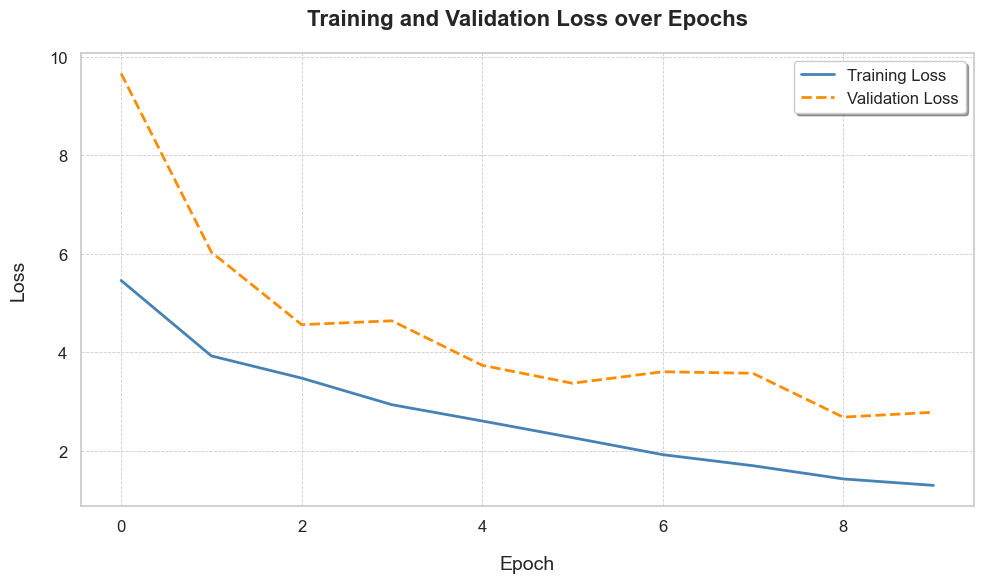

In [27]:
# Display loss
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
plt.plot(training_losses, label="Training Loss", color='steelblue', linestyle='-', linewidth=2)
plt.plot(validation_losses, label="Validation Loss", color='darkorange', linestyle='--', linewidth=2)

plt.xlabel("Epoch", fontsize=14, labelpad=15)
plt.ylabel("Loss", fontsize=14, labelpad=15)
plt.title("Training and Validation Loss over Epochs", fontsize=16, fontweight='bold', pad=20)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(loc="upper right", fontsize=12, frameon=True, shadow=True)
plt.grid(True, which='both', linestyle='--', linewidth=0.6)
plt.tight_layout()

plt.savefig("training_validation_loss.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

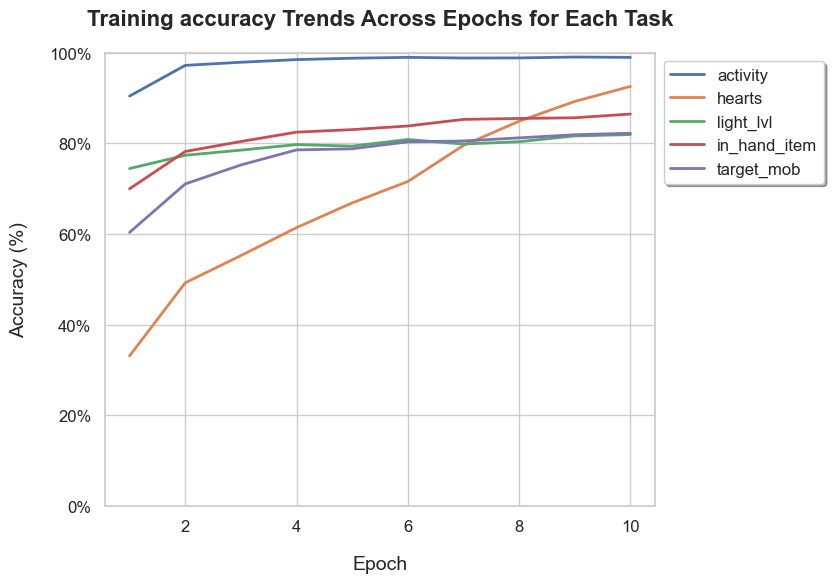

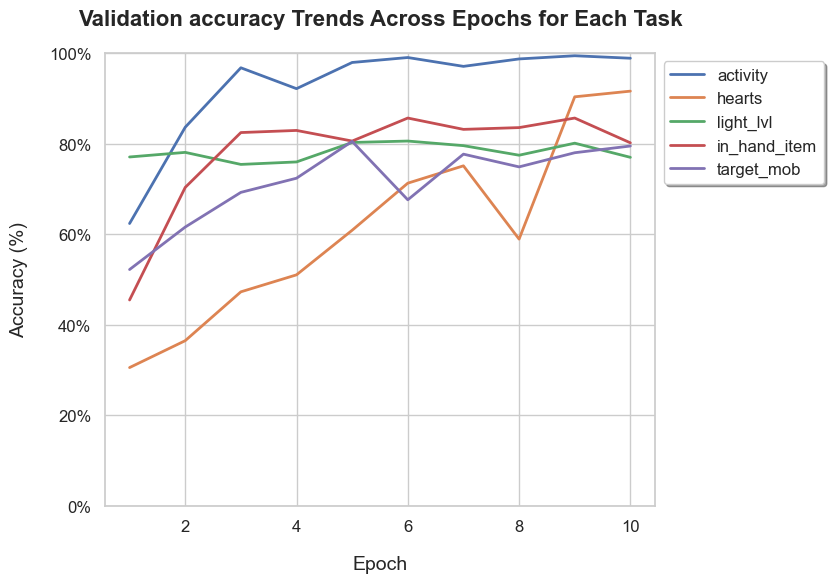

In [42]:
# Display accuracies V1
for name, accuracies in zip(("Training", "Validation"), (training_accuracies, validation_accuracies)):
    sns.set(style="whitegrid")
    
    plt.figure(figsize=(10, 6))
    for key, values in accuracies.items():
        plt.plot(epochs, values, label=key, linewidth=2)
    
    plt.title(f'{name} accuracy Trends Across Epochs for Each Task', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Epoch', fontsize=14, labelpad=15)
    plt.ylabel('Accuracy (%)', fontsize=14, labelpad=15)
    
    plt.ylim(0, 1)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12, frameon=True, shadow=True)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    
    plt.savefig(f"{name.lower()}_accuracy_trends.png", format='png', dpi=300, bbox_inches='tight')
    plt.show()

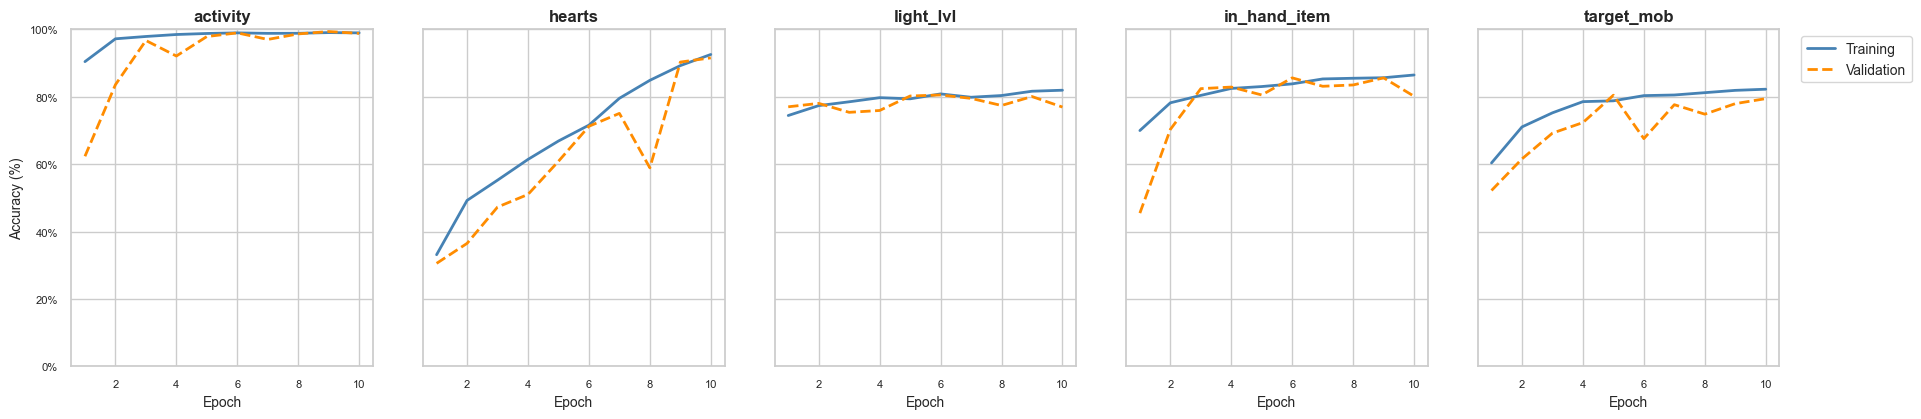

In [40]:
# Display accuracies V2
sns.set(style="whitegrid")

fig, axs = plt.subplots(1, len(training_accuracies), figsize=(20, 5), sharey=True)

for idx, (key, train_values) in enumerate(training_accuracies.items()):
    val_values = validation_accuracies[key]

    axs[idx].plot(epochs, train_values, label='Training', color='steelblue', linewidth=2)
    axs[idx].plot(epochs, val_values, label='Validation', color='darkorange', linestyle='--', linewidth=2)

    axs[idx].set_title(key, fontsize=12, fontweight='bold')
    axs[idx].set_xlabel('Epoch', fontsize=10)
    if idx == 0:
        axs[idx].set_ylabel('Accuracy (%)', fontsize=10)
    axs[idx].set_ylim(0, 1)
    axs[idx].tick_params(axis='both', labelsize=8)

    axs[idx].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))


plt.legend(['Training', 'Validation'], loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)
plt.tight_layout(pad=3.0)


plt.savefig("accuracy_trends_subplots.png", format='png', dpi=300, bbox_inches='tight')
plt.show()